# Predict geolocation from Received Signal Strenght Indicator (RSSI)

### Telecom ParisTech - MS Big Data - INF730

#### Anatoli de BRADKE, Philippe JACQUET, Raphael LEDERMAN and Sami NAKOURI

Dans ce projet, nous avons créé un modèle de prédiction de la géolocalisation d'objets connectés à partir de la position des balises ayant reçu leurs signaux et de la force ce signaux. 

Nous avons dans un premier temps réalisé une étude approfondie des données fournies par Sigfox, détaillée dans la suite de ce notebook, et ainsi pu mettre en évidence la présence de stations très lointaines n'apportant pas d'information crédible pour notre objectif.

Nous avons ensuite créé une matrice de variables explicatives (features) en nous basant sur le dataset original. Dans un premier temps nous avons regroupé les données par messages ID et ajouté les variables suivantes: 
- One-hot-encoder pour chacune des stations: valeur du RSSI si la station a reçu le message, 0 sinon
- Barycentre de la latitude et longitude des stations ayant reçu le message.
- L'introduction de la variable NSEQ ne nous ayant apporté aucune amélioration significative, nous avons décider  de ne pas en tenir compte dans notre listes de variables.

Enfin nous avons appliqué plusieurs modèles de Marchine Learning pour réaliser nos prédictions comme les Support vector machine, des Random Forest et des Extra trees, ou encore des K-Nearest Neighbors. Pour chacun d'entre eux, nous avons tester leurs performance en réalisant une cross-validation Leave one out device afin de ne jamais se trouver en situation d'overfiting.

## Python Libraries

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
os.environ['PROJ_LIB'] = "/anaconda3/share/proj"

import numpy as np
import math

import pandas as pd
pd.options.display.max_columns = 100

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import linear_model
from sklearn import tree
from sklearn import svm

from geopy.distance import vincenty, distance

from mpl_toolkits.basemap import Basemap

from myGeolocLibrary import *

## 1 - Data Visualization

### a. Import data

In [62]:
# Import train dataset
df_mess_train = pd.read_csv('Data/mess_train_list.csv')

# Import message position of train dataset
pos_train = pd.read_csv('Data/pos_train_list.csv')

# Import test dataset
df_mess_test = pd.read_csv('Data/mess_test_list.csv')

# Display train dataset
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


### b. Base Station list

In [63]:
# Determine all Base stations (in train and test dataset)
bs_list = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid']))

# Display number of Base Station
print("Number of Bases Stations that received at least 1 message: {}".format(len(bs_list)))

# Build dictionary {Key: base station id - Value: number of messages received}
bs_messages_dict = {}

for key, element in df_mess_train.groupby("bsid"):
    bs_messages_dict[int(key)] = element["messid"].unique().shape[0]

# Sort by number of messages descending    
bs_messages_dict = dict(sorted(bs_messages_dict.items(), key=lambda kv: -kv[1]))

# Print result
print()
print("Top 10 bases stations:")
for key in list(bs_messages_dict.keys())[0:10]:
    print("Base Station ID {} : {} messages received".format(key,bs_messages_dict[key]))

Number of Bases Stations that received at least 1 message: 259

Top 10 bases stations:
Base Station ID 1878 : 1128 messages received
Base Station ID 2189 : 1073 messages received
Base Station ID 1859 : 987 messages received
Base Station ID 8446 : 888 messages received
Base Station ID 3562 : 866 messages received
Base Station ID 4157 : 688 messages received
Base Station ID 2617 : 673 messages received
Base Station ID 4058 : 672 messages received
Base Station ID 2999 : 606 messages received
Base Station ID 10162 : 597 messages received


### c. Device list

In [64]:
# Determine all Base stations (in train and test dataset)
device_list = np.union1d(np.unique(df_mess_train['did']), np.unique(df_mess_test['did']))

# Display number of Base Station
print("Number of Device that sent at least 1 message: {}".format(len(device_list)))

# Build dictionary {Key: Device id - Value: number of messages sent}
device_messages_dict = {}

for key, element in df_mess_train.groupby("did"):
    device_messages_dict[int(key)] = element["messid"].unique().shape[0]

# Sort by number of messages descending    
device_messages_dict = dict(sorted(device_messages_dict.items(), key=lambda kv: -kv[1]))

# Print result
print()
print("Top 10 device:")
for key in list(device_messages_dict.keys())[0:10]:
    print("Device ID {} : {} messages sent".format(key,device_messages_dict[key]))

Number of Device that sent at least 1 message: 169

Top 10 device:
Device ID 476185 : 918 messages sent
Device ID 476327 : 681 messages sent
Device ID 476521 : 515 messages sent
Device ID 476889 : 369 messages sent
Device ID 476512 : 313 messages sent
Device ID 474192 : 299 messages sent
Device ID 473796 : 281 messages sent
Device ID 474176 : 249 messages sent
Device ID 476609 : 180 messages sent
Device ID 473335 : 127 messages sent


### d. Compute distance between base station and message

In [65]:
# Combine train dataset (df_mess_train) and related message position (pos_train)
df_mess_train[['mess_lat', 'mess_lng']] = pos_train

# Compute all distances between base station and message
df_mess_train['dist'] = df_mess_train.apply(compute_dist_msg_bs, axis=1)

# Display train dataset
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,mess_lat,mess_lng,dist
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343,410.187373
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954,1134.199650
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.026616
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463,2.253626
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440,4.687027
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730,9.826984
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289,3623.639974


### e. Base stations positions

In [66]:
# Group training set by stations
gdf_bs = df_mess_train.groupby("bsid").mean()

# Get latitudes and longitudes of base stations in the training set
bs_lats = gdf_bs["bs_lat"]
bs_lngs = gdf_bs["bs_lng"]

# Base stations in test set but not in training set
new_stations = np.setdiff1d(np.unique(df_mess_test['bsid']), np.unique(df_mess_train['bsid']))

# Group test set by stations
gdf_bs = df_mess_test[df_mess_test["bs_lat"] < 100].groupby("bsid").mean()

# Get latitudes and longitudes of base stations in test set but not in training set
bs_test_lats = gdf_bs.loc[new_stations]["bs_lat"].values
bs_test_lngs = gdf_bs.loc[new_stations]["bs_lng"].values

### f. Interactive Device plot

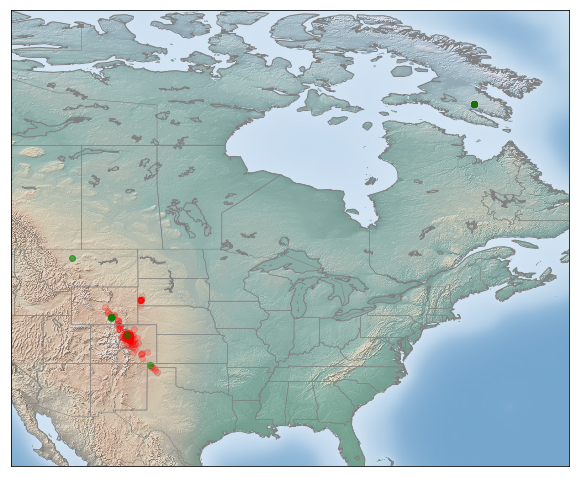

In [67]:

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
'   ____    _            __                              ____    _           _     '
'  / ___|  (_)   __ _   / _|   ___   __  __             |  _ \  | |   ___   | |_   '
'  \___ \  | |  / _` | | |_   / _ \  \ \/ /    _____    | |_) | | |  / _ \  | __|  '
'   ___) | | | | (_| | |  _| | (_) |  >  <    |_____|   |  __/  | | | (_) | | |_   '
'  |____/  |_|  \__, | |_|    \___/  /_/\_\             |_|     |_|  \___/   \__|  '
'               |___/                                                              '
'                                                                                  '
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


#################################################################################
#                   Interactive plot for one device messages
#################################################################################

# Select a device id
did = 476609

#################################################################################
#                    Save data to csv and make plot
#################################################################################

# Get messages coordinates and timestamp
messages_from_device = df_mess_train.groupby("did").get_group(did).groupby("messid").mean().sort_values(by = "time_ux", ascending=False)

mess_lats = messages_from_device["mess_lat"].values
mess_lngs = messages_from_device["mess_lng"].values
mess_timestamps = messages_from_device["time_ux"].apply(ux_to_timestamp).values

# Save messages coordinates and training set base stations coordinates to csv (filepath --> ./data.csv)
coords_to_csv(np.hstack([mess_lats, bs_lats]) , np.hstack([mess_lngs, bs_lngs]),\
              np.hstack([np.zeros(mess_lats.shape[0]), np.zeros(bs_lats.shape[0]) + 1]))

# Set plot limits 
llcrnrlon = min(mess_lngs.min(), bs_lngs.min())
llcrnrlat = min(mess_lats.min(), bs_lats.min())
urcrnrlon = max(mess_lngs.max(), bs_lngs.max())
urcrnrlat = max(mess_lats.max(), bs_lats.max())

# Define figure and ax objects
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Enable zooming
zoom_factory(ax)

# Annotation object used to display messages timestamps
annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# Basemap object
m = Basemap(projection='cyl', resolution='l', 
            llcrnrlon=llcrnrlon - 10, llcrnrlat=llcrnrlat - 10,
            urcrnrlon=urcrnrlon + 10, urcrnrlat=urcrnrlat + 10)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# Scatter plots of messages positions, training set base stations positions
# and positions for base stations that are in test set but not in traning set
sc = m.scatter(mess_lngs, mess_lats, latlon=True, c = "blue", alpha=0.4)
m.scatter(bs_lngs, bs_lats, latlon=True, c = "red", alpha=0.2)
m.scatter(bs_test_lngs, bs_test_lats, latlon=True, c = "green", alpha=0.6)

#################################################################################
#                        PLOT INTERACTIONS FUNCTIONS
#################################################################################

#################################################################################
#                   convert x/y values in the bottom right corner of 
#                   the plot to lat/long
#################################################################################

# convert x/y value back to lat/long
def format_coord(x, y, basemap):
    return 'x=%.4f, y=%.4f'%(basemap(x, y, inverse = True))

ax.format_coord = lambda x,y:format_coord(x, y, m)

#################################################################################
#            click handler to measure distance between two points on map:
#            - first click displays first point coordinates
#            - second click displays first and second points coordinates, 
#              and distance between them in km
#################################################################################

i = 0
first_click_coor = []
second_click_coor = []


def onclick(event):
    
    global i
    global first_click_coor
    global second_click_coor
    
    if i%2 == 0:
        first_click_coor.clear()
        second_click_coor.clear()
        first_click_coor.append(np.round(event.ydata, 2))
        first_click_coor.append(np.round(event.xdata, 2))
        
    else :
        second_click_coor.append(np.round(event.ydata, 2))
        second_click_coor.append(np.round(event.xdata, 1))
        
    txt = ','.join(map(str, first_click_coor)) +  '\n' + ','.join(map(str,second_click_coor))    
    
    if (len(first_click_coor) & len(second_click_coor)) == 2:
        txt += '\n' + str(np.round(distance(first_click_coor, second_click_coor).km, 3)) + ' km'
    
    fig.suptitle(txt)
    fig.canvas.draw_idle()
    i += 1

fig.canvas.mpl_connect('button_press_event', onclick)

#################################################################################
#            hover handler to display messages timestamps
#################################################################################


def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([mess_timestamps[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover);

#################################################################################
#                                  END
#################################################################################

## 2 - Data Preprocessing

### a. Remove outlier

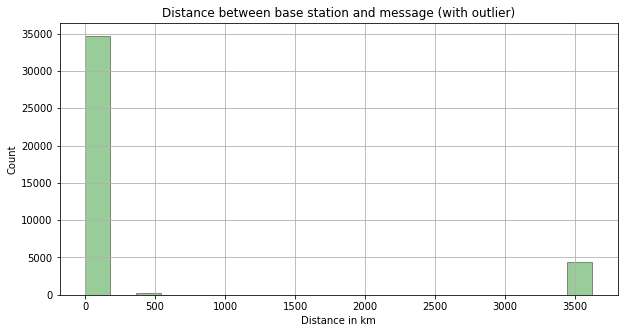

In [68]:
# Plot histogramme with outlier
fig = plt.figure(0, figsize=(10, 5))
plt.hist(df_mess_train['dist'],bins=20,facecolor='green',alpha=0.4, ec='black')
plt.title("Distance between base station and message (with outlier)")
plt.xlabel('Distance in km')
plt.ylabel('Count')
plt.grid()
plt.show()

In [69]:
# Remove outlier (distance over  1000 km)
df_mess_train = df_mess_train[df_mess_train['dist'] < 1000]

# Display statistics
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,mess_lat,mess_lng,dist
count,34861.000000,3.486100e+04,34861.000000,34861.000000,3.486100e+04,34861.000000,34861.000000,34861.000000,34861.000000,34861.000000
mean,4330.969020,4.817002e+05,1.044132,-125.934430,1.473027e+12,39.817302,-105.057619,39.786343,-105.059675,7.891587
std,2360.556415,8.595609e+04,0.558647,9.223712,5.574179e+09,0.349878,0.201467,0.217172,0.171645,31.713886
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.026616
25%,2790.000000,4.761400e+05,1.000000,-132.500000,1.467927e+12,39.744848,-105.077530,39.708777,-105.063488,2.026689
50%,3554.000000,4.763150e+05,1.000000,-127.500000,1.472834e+12,39.781464,-105.050984,39.777484,-105.041622,4.017617
75%,4790.000000,4.766060e+05,1.500000,-121.000000,1.478775e+12,39.816224,-105.010048,39.806971,-105.018756,7.586628
max,10148.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,43.725754,-102.011461,43.140387,-102.094289,453.889878


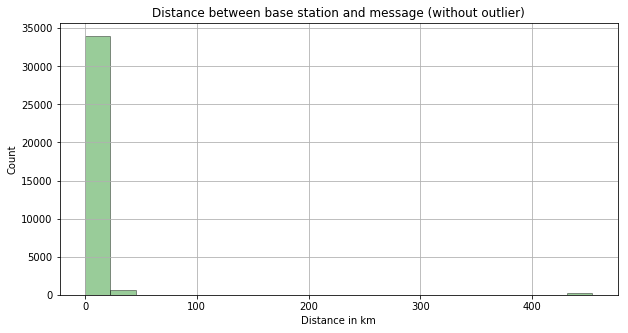

In [70]:
# Plot histogramme without outlier
fig = plt.figure(1, figsize=(10, 5))
plt.hist(df_mess_train['dist'],bins=20,facecolor='green',alpha=0.4, ec='black')
plt.title("Distance between base station and message (without outlier)")
plt.xlabel('Distance in km')
plt.ylabel('Count')
plt.grid()
plt.show()

### b. Build features

In [71]:
# Feature Matrix construction
def feat_mat_const(df, listOfBs):

    # Group data by message ID
    df_mess_bs_group = df.groupby(['messid'], as_index=False)

    # Number of message ID
    nb_mess = len(np.unique(df['messid']))
    
    # Columns list
    columns = listOfBs.tolist() + [x + max(listOfBs) for x in listOfBs.tolist()] + ["bar_lat", "bar_lng"]

    # Initialize feature dataframe
    df_feat = pd.DataFrame(np.zeros((nb_mess, 2 * len(listOfBs) + 2)), columns = columns)

    # Calculate features for each message ID
    idx = 0
    id_list = [0] * nb_mess
    for key, elmt in df_mess_bs_group:

        # Exponential rssi
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = np.array(list((df_mess_bs_group.get_group(key)['rssi'])))
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid'] + max(listOfBs)] = 1
        df_feat.loc[idx, 'bar_lat'] = np.sum(df_mess_bs_group.get_group(key)['rssi'] * df_mess_bs_group.get_group(key)['bs_lat']) / df_mess_bs_group.get_group(key)['rssi'].sum()
        df_feat.loc[idx, 'bar_lng'] = np.sum(df_mess_bs_group.get_group(key)['rssi'] * df_mess_bs_group.get_group(key)['bs_lng']) / df_mess_bs_group.get_group(key)['rssi'].sum()
        
        # Get message id list
        id_list[idx] = key

        # Next message
        idx = idx + 1

    # Return results
    return df_feat, id_list

In [72]:
# Build features matrix
df_feat, id_list_train = feat_mat_const(df_mess_train, bs_list)

# Normalize features 
scaler = preprocessing.StandardScaler()
df_feat = scaler.fit_transform(df_feat.values)

### c. Build ground truth

In [74]:
# Build ground truth
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth = pd.DataFrame(np.transpose([ground_truth_lat, ground_truth_lng]), columns=['lat', 'lng'])

### d. Train and test dataset

In [75]:
# Build k-folds leave one out device
def one_device_out(did, dids):
    indices = np.where(dids)[0]
    did_indices = np.where(dids == did)[0]
    return (np.setdiff1d(indices, did_indices), did_indices)

# List of unique device ID
dids = np.array(df_mess_train.groupby(['messid'], as_index=False).mean()["did"])

# Leave one out device list index
cvs = list(map(lambda did : one_device_out(did, dids), np.unique(dids)))

## 3 - Machine Learning

## Support Vector Regression

### a. Cross validation hyperparameter tuning

In [30]:
# Initialize regressor
regressor = svm.SVR(kernel='rbf')

# Build param grid
param_grid = {'gamma':[0.0001, 0.001, 0.01, 0.1], 'C':[0.0001, 0.001, 0.01, 0.1]}

# Find best parameter
best_param_lat, best_param_lng = cv_best_param(regressor, param_grid, df_feat, ground_truth["lat"], ground_truth["lng"], df_feat, cvs[:10])

# Display best param for latitude and longitude models
print('Cross-Validation best model for latitude:')
print(best_param_lat)
print()
print('Cross-Validation best model for longitude:')
print(best_param_lng)

Cross-Validation best model for latitude:
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Cross-Validation best model for longitude:
SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


### b. Fit best model and Predict on test set

In [33]:
# Initialize regressor
best_regressor_lat = svm.SVR(kernel='rbf', gamma=0.1, C=0.1)
best_regressor_lng = svm.SVR(kernel='rbf', gamma=0.001, C=0.001)

# Make prediction
y_pred_lat = cross_val_predict(best_regressor_lat, df_feat, ground_truth["lat"], cv=cvs)
y_pred_lng = cross_val_predict(best_regressor_lng, df_feat, ground_truth["lng"], cv=cvs)

### c. Evaluate results

Error @ 80%: 15.3 km


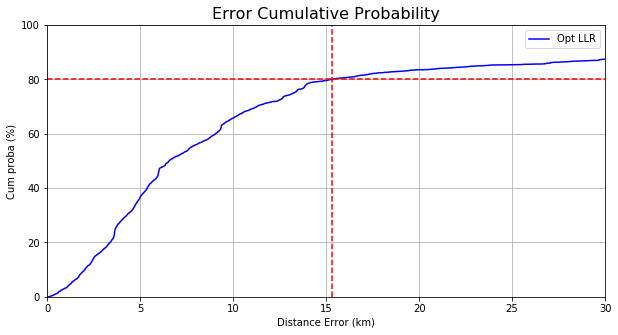

In [33]:
# Calculate prediction error
err_vec = Eval_geoloc(ground_truth["lat"], ground_truth["lng"], y_pred_lat, y_pred_lng)

# Calculate 80% percentile
percentile_80 = np.percentile(err_vec, 80)

# Calculate cumulative prediction error
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

# Plot error distribution
fig = plt.figure(2, figsize=(10, 5))
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='b')
plt.axvline(x=percentile_80 / 1000, c = "r", linestyle='--')
plt.axhline(y =80, c = "r", linestyle='--')
plt.grid()
plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability', fontsize=16)
plt.legend( ["Opt LLR"])
plt.show

# Display 80% percentile
print("Error @ 80%: {} km".format(round(percentile_80 / 1000, 2)))

### d. Construct test prediction

In [76]:
# Build features matrix
df_feat_test, id_list_test = feat_mat_const(df_mess_test, bs_list)

# Normalize features 
df_feat_test = scaler.transform(df_feat_test.values)

# Fit model and Predict
y_pred_lat, y_pred_lng = regressor_and_predict(best_regressor_lat, best_regressor_lng, df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

# Build prediction dataframe
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

# Export results to csv
test_res.to_csv('Prediction/svm_pred_pos_test_list.csv', index=False)

## Regression ExtraTrees

### a. Cross validation hyperparameter tuning

In [36]:
# Initialize regressor
regressor = ensemble.ExtraTreesRegressor()

# Build param grid
param_grid = {"max_depth": [100, 200, 300, None], "n_estimators": [200, 300, 500], "min_samples_split": [5, 10, 15], "min_samples_leaf":[1,2,3,5]}
param_grid = {"max_depth": [50, 100, None], "n_estimators": [100, 150]}


# Find best parameter
best_param_lat, best_param_lng = cv_best_param(regressor, param_grid, df_feat, ground_truth["lat"], ground_truth["lng"], df_feat, cvs[:10])


# Display best param for latitude and longitude models
print('Cross-Validation best model for latitude:')
print(best_param_lat)
print()
print('Cross-Validation best model for longitude:')
print(best_param_lng)

Cross-Validation best model for latitude:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Cross-Validation best model for longitude:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


### b. Fit best model and Predict on test set

In [15]:
# Initialize best regressor
best_regressor_lat = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
best_regressor_lng = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Make prediction
y_pred_lat = cross_val_predict(best_regressor_lat, df_feat, ground_truth["lat"], cv=cvs)
y_pred_lng = cross_val_predict(best_regressor_lng, df_feat, ground_truth["lng"], cv=cvs)

### c. Evaluate results

Error @ 80%: 7.4 km


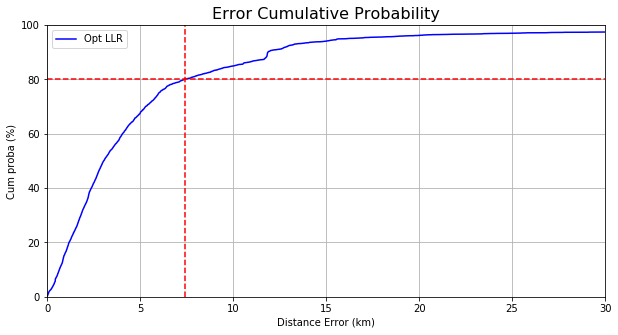

In [16]:
# Calculate prediction error
err_vec = Eval_geoloc(ground_truth["lat"], ground_truth["lng"], y_pred_lat, y_pred_lng)

# Calculate 80% percentile
percentile_80 = np.percentile(err_vec, 80)

# Calculate cumulative prediction error
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

# Plot error distribution
fig = plt.figure(2, figsize=(10, 5))
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='b')
plt.axvline(x=percentile_80 / 1000, c = "r", linestyle='--')
plt.axhline(y =80, c = "r", linestyle='--')
plt.grid()
plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability', fontsize=16)
plt.legend(["Opt LLR"])
plt.show

# Display 80% percentile
print("Error @ 80%: {} km".format(round(percentile_80 / 1000, 2)))

### d. Construct test prediction

In [ ]:
# Build features matrix
df_feat_test, id_list_test = feat_mat_const(df_mess_test, bs_list)

# Normalize features 
df_feat_test = scaler.transform(df_feat_test.values)

# Fit model and Predict
y_pred_lat, y_pred_lng = regressor_and_predict(best_regressor_lat, best_regressor_lng, df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

# Build prediction dataframe
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

# Export results to csv
test_res.to_csv('Prediction/extratree_pred_pos_test_list.csv', index=False)

## Regression KNN

### a. Cross validation hyperparameter tuning

In [45]:
# Initialize regressor
regressor = neighbors.KNeighborsRegressor()

# Build param grid
param_grid = {'weights':['uniform', 'distance'], 'n_neighbors':[4, 5, 6, 7, 10]}

# Find best parameter
best_param_lat, best_param_lng = cv_best_param(regressor, param_grid, df_feat, ground_truth["lat"], ground_truth["lng"], df_feat, cvs[:10])

# Display best param for latitude and longitude models
print('Cross-Validation best model for latitude:')
print(best_param_lat)
print()
print('Cross-Validation best model for longitude:')
print(best_param_lng)

Cross-Validation best model for latitude:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

Cross-Validation best model for longitude:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')


### b. Fit best model and Predict on test set

In [27]:
# Initialize best regressor
best_regressor_lat = neighbors.KNeighborsRegressor(weights='uniform', n_neighbors=4)
best_regressor_lng = neighbors.KNeighborsRegressor(weights='uniform', n_neighbors=4)

# Make prediction
y_pred_lat = cross_val_predict(best_regressor_lat, df_feat, ground_truth["lat"], cv=cvs)
y_pred_lng = cross_val_predict(best_regressor_lng, df_feat, ground_truth["lng"], cv=cvs)

### c. Evaluate results

Error @ 80%: 6.16 km


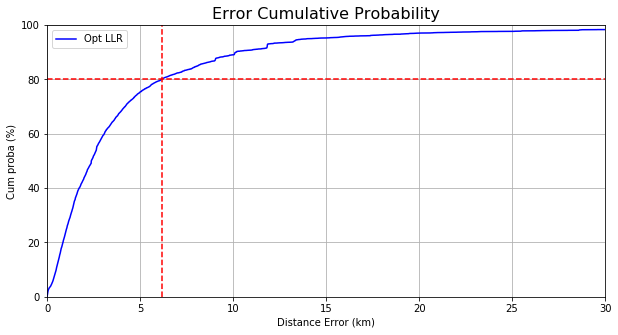

In [28]:
# Calculate prediction error
err_vec = Eval_geoloc(ground_truth["lat"], ground_truth["lng"], y_pred_lat, y_pred_lng)

# Calculate 80% percentile
percentile_80 = np.percentile(err_vec, 80)

# Calculate cumulative prediction error
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 

# Plot error distribution
fig = plt.figure(2, figsize=(10, 5))
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='b')
plt.axvline(x=percentile_80 / 1000, c = "r", linestyle='--')
plt.axhline(y =80, c = "r", linestyle='--')
plt.grid()
plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability', fontsize=16)
plt.legend( ["Opt LLR"])
plt.show

# Display 80% percentile
print("Error @ 80%: {} km".format(round(percentile_80 / 1000, 2)))

### d. Construct test prediction

In [78]:
# Build features matrix
df_feat_test, id_list_test = feat_mat_const(df_mess_test, bs_list)

# Normalize features 
df_feat_test = scaler.transform(df_feat_test.values)

# Fit model and Predict
y_pred_lat, y_pred_lng = regressor_and_predict(best_regressor_lat, best_regressor_lng, df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

# Build prediction dataframe
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

# Export results to csv
test_res.to_csv('Prediction/knn_pred_pos_test_list.csv', index=False)